In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import get_param_dict
from src.data import plot_data

In [4]:
cells_df = pd.read_parquet('dl_data/300_cells_df.parquet.gzip')

In [5]:
cells_df.head()

,position_x,position_y,cell_type,total_volume,current_phase,nuclear_volume,sensitivity_to_TNF_chemotaxis,sensitivity_to_debris_chemotaxis,debris_secretion_rate,activated_TNF_secretion_rate,activated_immune_cell,timestep
ID,,,,,,,,,,,,
0,246.263489,119.905548,macrophage,4973.444562,G0G1_phase,492.142638,10.0,1.0,1.0,1.0,1.0,12
1,259.410343,133.137973,macrophage,4906.440155,G0G1_phase,487.603791,10.0,1.0,1.0,1.0,1.0,12
2,239.734353,94.771358,macrophage,4969.372097,G0G1_phase,491.313914,10.0,1.0,1.0,1.0,1.0,12
4,264.286282,116.224108,macrophage,4914.459740,G0G1_phase,488.450867,10.0,1.0,1.0,1.0,1.0,12
10,224.717191,74.478444,cancer_cell,4846.796764,G2_phase,1059.442406,10.0,1.0,1.0,1.0,0.0,12


In [6]:
df = cells_df[cells_df['timestep'] == 50]

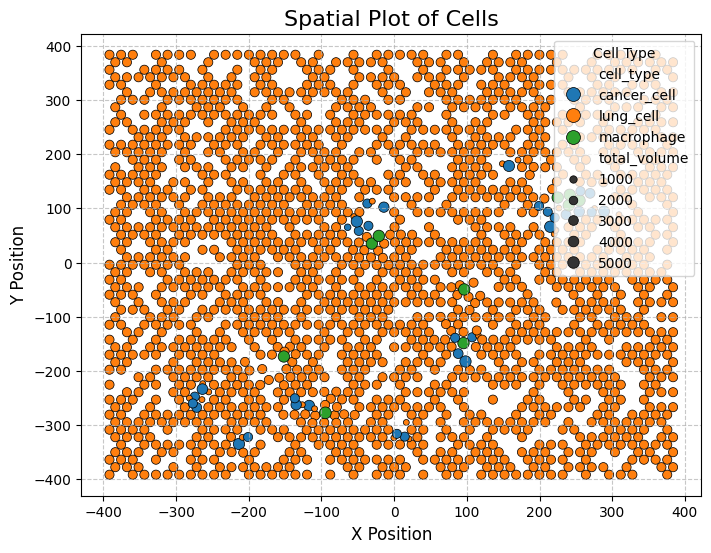

In [7]:
# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x='position_x',
    y='position_y',
    hue='cell_type',
	size='total_volume',
    palette='tab10',  # Choose a colormap
    s=100,  # Size of markers
    edgecolor='black'
)
plt.title('Spatial Plot of Cells', fontsize=16)
plt.xlabel('X Position', fontsize=12)
plt.ylabel('Y Position', fontsize=12)
plt.legend(title='Cell Type', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

This matches what we have in the studio

In [8]:
grid = pd.read_csv('dl_data/grid.csv')

In [9]:
grid.loc[300]

num_sims_per_theta     2
theta_id              44
Name: 300, dtype: int64

In [10]:
theta = np.load('dl_data/theta.npy')

In [11]:
theta[44]

array([2.875000e-09, 9.062500e-02, 5.343750e-01, 4.375000e-10,
       1.656250e-01, 3.656250e-01, 3.437500e-01, 2.056250e-06,
       2.028125e-04, 6.890625e-04])

In [12]:
params_dict = get_param_dict()
params_dict

{'macrophage_max_recruitment_rate': [0, 8e-09],
 'macrophage_recruitment_min_signal': [0, 0.2],
 'macrophage_recruitment_saturation_signal': [0, 0.6],
 'DC_max_recruitment_rate': [0, 4e-09],
 'DC_recruitment_min_signal': [0, 0.2],
 'DC_recruitment_saturation_signal': [0, 0.6],
 'DC_leave_rate': [0, 0.4],
 'Th1_decay': [0, 2.8e-06],
 'T_Cell_Recruitment': [0, 0.00022],
 'DM_decay': [0, 0.0007]}

In [13]:
data = np.load('dl_data/50_data.npy')

In [14]:
data.shape

(1, 20, 64, 64)

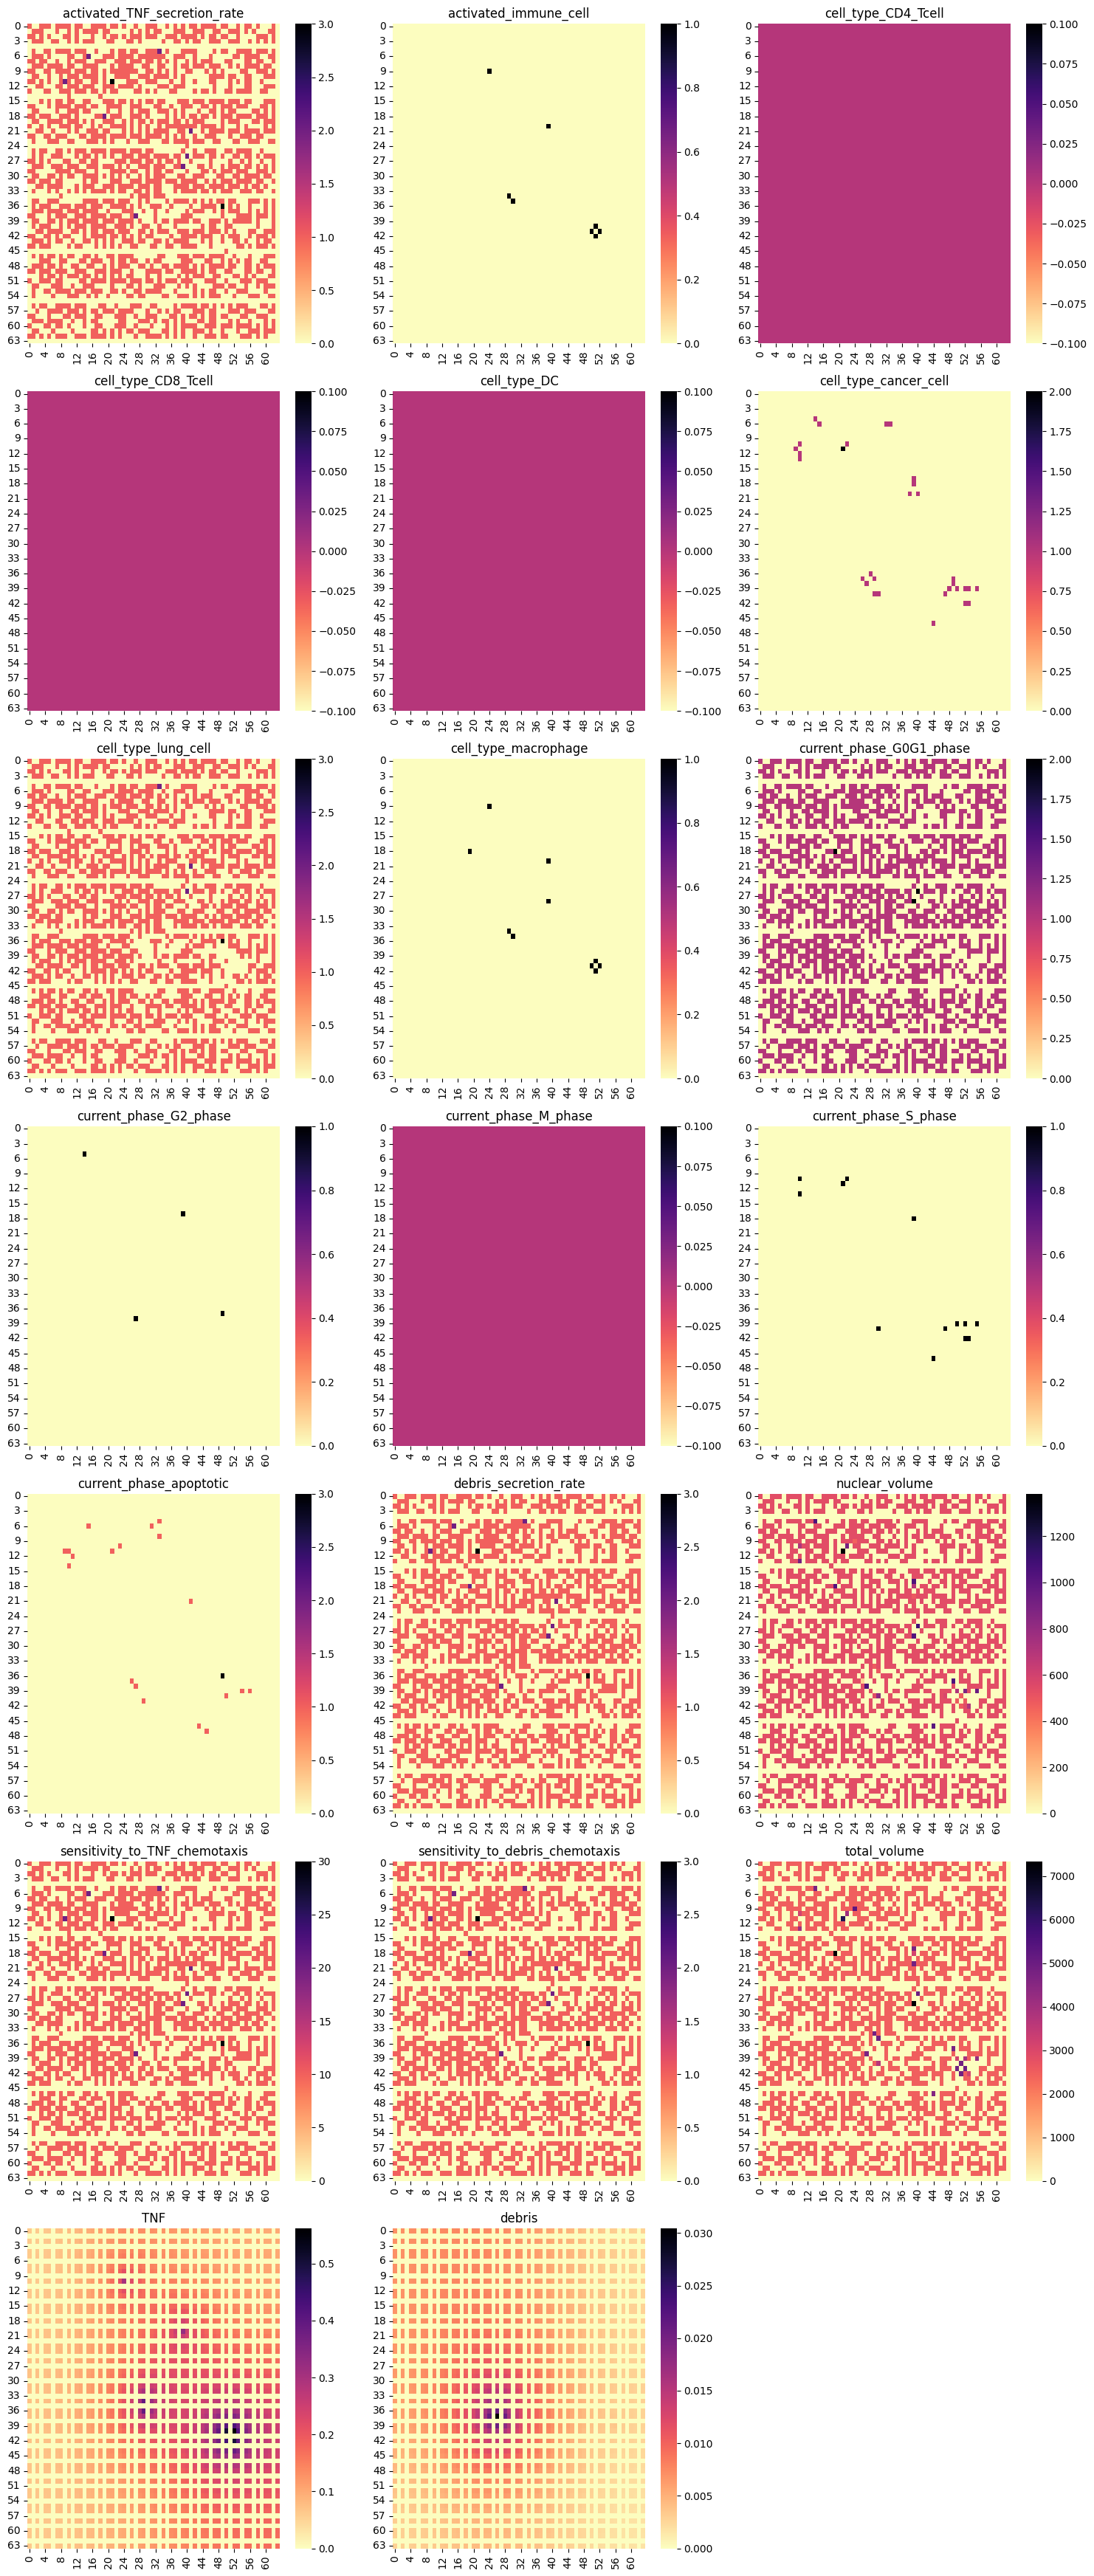

In [15]:
plot_data(data[0])

In [22]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull

def pixellate_grid(x, y, types, image_ids, nx, ny):
    # Determine the max range in either x or y for uniform scaling
    max_range = max(max(x) - min(x), max(y) - min(y))

    unique_image_ids = np.unique(image_ids)

    # Scaling x and y to fit in [0, R1] x [0, R2]
    x_scaled = (x - np.min(x)) / max_range
    y_scaled = (y - np.min(y)) / max_range

    # Create a DataFrame for the scaled points
    points_df = pd.DataFrame({'x': x_scaled, 'y': y_scaled, 'image_id': image_ids})

    # Creating the pixel boundaries
    x_bins = np.linspace(0, np.max(x_scaled), nx + 1)
    y_bins = np.linspace(0, np.max(y_scaled), ny + 1)

    # Assigning each point to a pixel
    points_df['x_pixel'] = np.digitize(x_scaled, bins=x_bins, right=False)
    points_df['y_pixel'] = np.digitize(y_scaled, bins=y_bins, right=False)

    # Create a dataframe with pixel and image information
    points_df['type'] = types

    # Count the number of points of each type in each pixel for each image
    pixel_counts = (
        points_df.groupby(['image_id', 'x_pixel', 'y_pixel', 'type'])
        .size()
        .reset_index(name='count')
        .pivot_table(index=['image_id', 'x_pixel', 'y_pixel'], 
                     columns='type', values='count', fill_value=0)
        .reset_index()
    )

    # Create the full grid of possible pixel combinations
    full_grid = pd.DataFrame([
        (image_id, x_pixel, y_pixel)
        for image_id in unique_image_ids
        for x_pixel in range(1, nx + 1)
        for y_pixel in range(1, ny + 1)
    ], columns=['image_id', 'x_pixel', 'y_pixel'])

    # Merge with the counts, ensuring missing combinations are filled
    final_df = full_grid.merge(pixel_counts, on=['image_id', 'x_pixel', 'y_pixel'], how='left')
    type_columns = pixel_counts.columns.difference(['image_id', 'x_pixel', 'y_pixel'])

    # Adding pixel center coordinates
    final_df['x'] = (x_bins[final_df['x_pixel'] - 1] + x_bins[final_df['x_pixel']]) / 2
    final_df['y'] = (y_bins[final_df['y_pixel'] - 1] + y_bins[final_df['y_pixel']]) / 2

    # Identify convex hull for each image
    counts = []
    for image_id in unique_image_ids:
        image_points = points_df[points_df['image_id'] == image_id][['x', 'y']].to_numpy()
        hull = ConvexHull(image_points) if len(image_points) >= 3 else None
        hull_polygon = hull.vertices if hull else []
        in_hull = [np.any(hull_polygon == idx) for idx in range(len(final_df))]
        counts.append(
            final_df.loc[final_df['image_id'] == image_id].assign(in_hull=in_hull)
        )

    # Adjust counts based on in_hull
    counts = pd.concat(counts)
    for col in type_columns:
        counts[col] = np.where(
            counts['in_hull'] & counts[col].isna(),
            0,
            counts[col]
        )
    counts = counts.drop(columns='in_hull')

    # Create output list of matrices for each image
    y_list = {}
    for image_id in unique_image_ids:
        sub_df = counts[counts['image_id'] == image_id]
        y_matrix = sub_df[type_columns].fillna(0).to_numpy()
        y_list[image_id] = y_matrix

    # Return the result as a dictionary
    return {'y_list': y_list, 'coords': final_df[['x', 'y']].drop_duplicates()}

In [24]:
x = df['position_x'].to_numpy()
y = df['position_y'].to_numpy()
types = df['cell_type'].to_numpy()
image_ids = df['timestep'].to_numpy()
nx = 32
ny = 32
out = pixellate_grid(x, y, types, image_ids, nx, ny)

In [25]:
out['y_list'][50].shape

(1024, 3)

In [27]:
out['coords'].head()

,x,y
0,0.015625,0.015624
1,0.015625,0.046872
2,0.015625,0.078121
3,0.015625,0.109369
4,0.015625,0.140617


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_y_list(y_list, coords):
    """
    Plot each image in y_list, faceted by types.

    Parameters:
    - y_list: Dictionary of y_list matrices from pixellate_grid.
    - coords: DataFrame containing the coordinates of each pixel center.

    Returns:
    - A list of matplotlib figure objects.
    """
    plots = []
    for image_id, y_matrix in y_list.items():
        # Convert y_matrix to a DataFrame and merge with coordinates
        y_df = pd.DataFrame(y_matrix, columns=[f'type_{j}' for j in range(y_matrix.shape[1])])
        plot_df = pd.concat([coords.reset_index(drop=True), y_df], axis=1)

        # Reshape to long format for faceted plotting
        melted_df = plot_df.melt(id_vars=['x', 'y'], var_name='type', value_name='count')

        # Prepare for tile plotting
        fig, axes = plt.subplots(
            nrows=1, ncols=y_matrix.shape[1], figsize=(5 * y_matrix.shape[1], 5), sharex=True, sharey=True
        )

        if y_matrix.shape[1] == 1:
            axes = [axes]  # Ensure axes is iterable if there's only one type

        for ax, (type_name, data) in zip(axes, melted_df.groupby('type')):
            # Pivot data for heatmap
            heatmap_data = data.pivot(index='y', columns='x', values='count')

            sns.heatmap(
                heatmap_data, ax=ax, cmap='magma', cbar=True, square=True,
                linewidths=0.1, linecolor='gray'
            )

            ax.set_title(f"Type: {type_name}")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")

        plt.suptitle(f"Image ID: {image_id}", y=1.02)
        plt.tight_layout()
        plots.append(fig)

    return plots
 

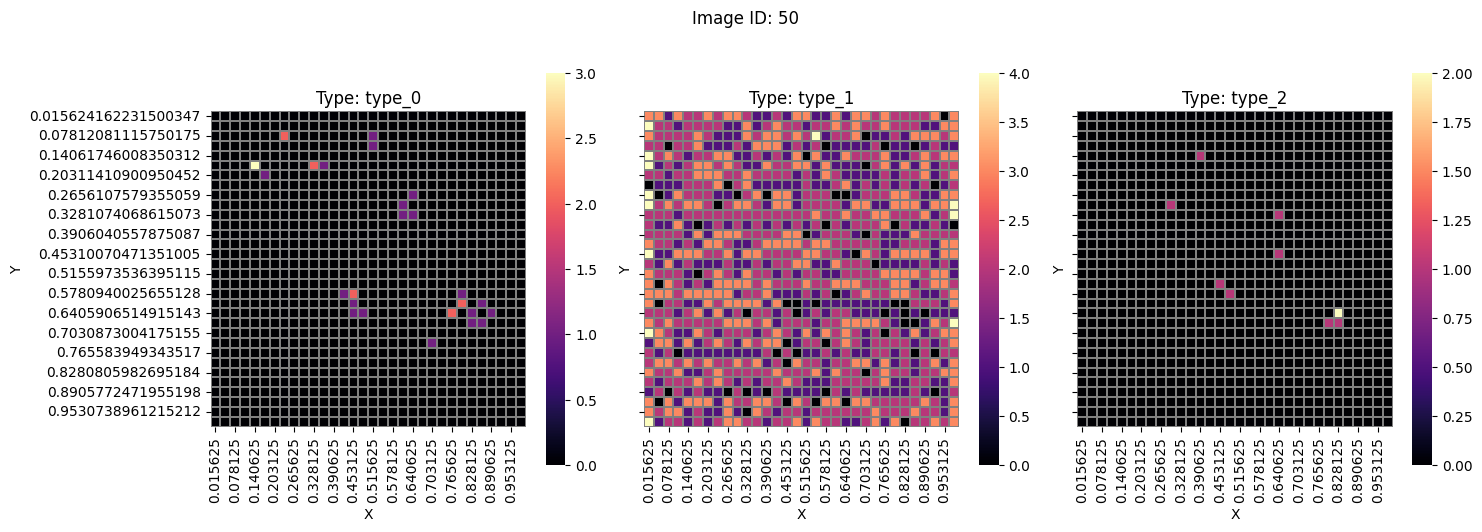

In [31]:
p = plot_y_list(out['y_list'], out['coords'])

In [32]:
theta = np.load('dl_data/theta.npy')

In [33]:
theta.shape

(128, 2)

In [34]:
theta

array([[0.00000e+00, 0.00000e+00],
       [4.00000e-09, 2.00000e-09],
       [6.00000e-09, 1.00000e-09],
       [2.00000e-09, 3.00000e-09],
       [3.00000e-09, 1.50000e-09],
       [7.00000e-09, 3.50000e-09],
       [5.00000e-09, 5.00000e-10],
       [1.00000e-09, 2.50000e-09],
       [1.50000e-09, 1.25000e-09],
       [5.50000e-09, 3.25000e-09],
       [7.50000e-09, 2.50000e-10],
       [3.50000e-09, 2.25000e-09],
       [2.50000e-09, 7.50000e-10],
       [6.50000e-09, 2.75000e-09],
       [4.50000e-09, 1.75000e-09],
       [5.00000e-10, 3.75000e-09],
       [7.50000e-10, 1.87500e-09],
       [4.75000e-09, 3.87500e-09],
       [6.75000e-09, 8.75000e-10],
       [2.75000e-09, 2.87500e-09],
       [3.75000e-09, 3.75000e-10],
       [7.75000e-09, 2.37500e-09],
       [5.75000e-09, 1.37500e-09],
       [1.75000e-09, 3.37500e-09],
       [1.25000e-09, 6.25000e-10],
       [5.25000e-09, 2.62500e-09],
       [7.25000e-09, 1.62500e-09],
       [3.25000e-09, 3.62500e-09],
       [2.25000e-09,